##Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive')

from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from skimage import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy.interpolate import NearestNDInterpolator, CloughTocher2DInterpolator
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys
from tabulate import tabulate
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor
from helper_functions import set_parameter_requires_grad, meshgrid2d, get_grid, plot_learning_curve, split_dataset, initialise_model, get_predictions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load test dataset

In [7]:
def get_dataloader(dataset, batch_size=16, shuffle=True):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
  return dataloader

TEST_DATA = "synthetic_dataset_test_2023-03-09"
!unzip -d "$TEST_DATA"/ /content/drive/MyDrive/synthetic_dataset/"$TEST_DATA".zip # unziping test data

test_dataset = TaiChiDataset(log_file=TEST_DATA+'/sample_ids.txt',
                              root_dir=TEST_DATA,
                              check=True,
                              transform=transforms.Compose([ToTensor()]))

print(len(test_dataset))
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

Archive:  /content/drive/MyDrive/synthetic_dataset/synthetic_dataset_test_2023-03-09.zip
replace synthetic_dataset_test_2023-03-09/coords/2165_2.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace synthetic_dataset_test_2023-03-09/coords/2165_2.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
857


## Evaluation helper functions

In [8]:
# load checkpoint
def load_checkpoint(filename):
  try:
    filepath = "/content/drive/MyDrive/checkpoints/"+filename
    
    checkpoint = torch.load(filepath, map_location='cuda:0')
    
    t_history = checkpoint['train_loss_history']
    v_history = checkpoint['val_loss_history']
    train_time = int(checkpoint['train_time'])

    t_losses = np.array([x[1] for x in t_history])
    v_losses = np.array([x[1] for x in v_history])

   
    t_min_arg = np.argmin(t_losses)
    v_min_arg = np.argmin(v_losses)

    print('-' * 50)
    print("Checkpoint data:")
    print("Best train loss: {:.3f} at epoch {}/{}".format(t_history[t_min_arg][1], t_history[t_min_arg][0], len(t_history)))
    print("Best valid loss: {:.3f} at epoch {}/{}".format(v_history[v_min_arg][1], v_history[v_min_arg][0], len(t_history)))
    print("Train time {}h".format(int(train_time)//3600))
    print('-' * 50)

    model_weights = checkpoint['model_weights']
    best_model_weights = checkpoint['best_weights']
    optimizer_state = checkpoint['optimizer']

    return model_weights, best_model_weights, t_history, v_history
  except Exception as e:
    print("ERROR could not load checkpoint:", e)

In [3]:
def run_evaluation(test_dataloader, checkpoint_file=None):
  device = 'cuda'
  running_mse = []
  running_accuracy = []

  running_ssim = []
  running_psnr = []
  running_ssim_CT = []
  running_psnr_CT = []

  running_ssim_GRID = []
  running_psnr_GRID = []
  running_ssim_GRID_CT = []
  running_psnr_GRID_CT = []

  samples = 0

  # initialise model with checkpoint
  # if no checkpoint use baseline (no prediction model)
  if checkpoint_file:
    model = initialise_model(device, to_learn=['all'])
    _, best_model_weights, _, _ = load_checkpoint(checkpoint_file)
    model.load_state_dict(best_model_weights)
    model.eval()
    
  else:
    model = BaselineModel().to(device)
    model.eval()

  # run model at each batch and get predictions 
  for i_batch, sample_batched in enumerate(test_dataloader):
    # if i_batch > 1:
    #   continue
    print("batch {} / {}".format(i_batch, len(test_dataloader)))
    batch_size = len(sample_batched['id'])
    samples += batch_size
    input1 = sample_batched['image0']
    input2 = sample_batched['image3']
    true_images = sample_batched['image7']
    inputs = torch.cat((input1, input2), dim=1)

    # Get ground truth coords and vis
    coords = sample_batched['coords']
    vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)

    inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
    coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
    vis = vis.to(device) # torch.Size([B, 1, 4096])

    with torch.no_grad():
      # Get model outputs 
      outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
      outputs = outputs['out'].to(device)
      outputs_coords = outputs[:, :2, :, :]
      outputs_vis = outputs[:, 2, :, :]
      outputs_vis = torch.where(outputs_vis > 0, 1.0, 0.0)

      outputs_coords_grid, outputs_vis_grid = get_predictions(device, outputs, coords, batch_size)
      outputs_vis_grid = torch.where(outputs_vis_grid > 0, 1.0, 0.0)
      outputs_coords = torch.permute(outputs_coords, (0, 2, 3, 1))
      outputs_vis = outputs_vis.view(batch_size,1,-1)
      outputs_coords = outputs_coords.view(batch_size,1,-1,2) # torch.Size([B, 1, 64*64, 2])

      
      # calculate stats
      # MSE and Accuracy
      running_mse.extend(compute_mse(coords.squeeze().cpu(), outputs_coords_grid.squeeze().cpu()))
      running_accuracy.extend(compute_accuracy(vis.squeeze().cpu(), outputs_vis_grid.squeeze().cpu()))


      # SSIM and PSNR on grid/full outptu for both NN anc CT reconstructions
      (ssim_NN, ssim_NN_G, ssim_CT, ssim_CT_G, psnr_NN, psnr_NN_G, psnr_CT, psnr_CT_G) = compute_ssim_psnr(input1, true_images,
                                                                                                           outputs_coords.cpu().numpy(), outputs_vis.cpu().numpy(),
                                                                                                           outputs_coords_grid.cpu().numpy(), outputs_vis_grid.cpu().numpy()) 
      running_ssim.extend(ssim_NN) 
      running_psnr.extend(psnr_NN)

      running_ssim_GRID.extend(ssim_NN_G)
      running_psnr_GRID.extend(psnr_NN_G)

      running_ssim_CT.extend(ssim_CT)
      running_psnr_CT.extend(psnr_CT)

      running_ssim_GRID_CT.extend(ssim_CT_G)
      running_psnr_GRID_CT.extend(psnr_CT_G)
  
  mse = np.mean(running_mse)
  mse_errror = np.std(running_mse)
  acc = np.mean(running_accuracy)
  acc_errror = np.std(running_accuracy)

  psnr = np.mean(running_psnr)
  psnr_error = np.std(running_psnr)
  psnr_GRID = np.mean(running_psnr_GRID)
  psnr_GRID_error = np.std(running_psnr_GRID)

  psnr_CT = np.mean(running_psnr_CT)
  psnr_error_CT = np.std(running_psnr_CT)
  psnr_GRID_CT = np.mean(running_psnr_GRID_CT)
  psnr_GRID_error_CT = np.std(running_psnr_GRID_CT)

  ssim = np.mean(running_ssim)
  ssim_error = np.std(running_ssim)
  ssim_GRID = np.mean(running_ssim_GRID)
  ssim_GRID_error = np.std(running_ssim_GRID)

  ssim_CT = np.mean(running_ssim_CT)
  ssim_error_CT = np.std(running_ssim_CT)
  ssim_GRID_CT = np.mean(running_ssim_GRID_CT)
  ssim_GRID_error_CT = np.std(running_ssim_GRID_CT)

  return (mse, mse_errror), (acc, acc_errror), (psnr, psnr_error), (ssim, ssim_error), (psnr_GRID, psnr_GRID_error), (ssim_GRID, ssim_GRID_error), (psnr_CT, psnr_error_CT), (ssim_CT, ssim_error_CT), (psnr_GRID_CT, psnr_GRID_error_CT), (ssim_GRID_CT, ssim_GRID_error_CT)

In [2]:
import math
def compute_mse(true_coords, pred_coords):
  mses = []
  batch_size = true_coords.shape[0]

  for i in range(batch_size):
    true_coord = true_coords[i]
    pred_coord = pred_coords[i]
    score = mean_squared_error(true_coord, pred_coord)
    mses.append(score) 

  return mses

def compute_accuracy(true_vis, pred_vis):
  # Compute classification accuracy between ground truth and predicted visibility
  acc_s = []
  batch_size = true_vis.shape[0]

  for i in range(batch_size):
    true_v = true_vis[i].numpy().flatten().astype(int)
    pred_v = pred_vis[i].numpy().flatten().astype(int)
    score = accuracy_score(true_v, pred_v, normalize=True)
    acc_s.append(score)

  return acc_s

def compute_ssim_psnr(images0, images7, coords, vis, coords_g, vis_g):
  ssim_NN = []
  psnr_NN = []
  ssim_NN_G = []
  psnr_NN_G = []

  ssim_CT = []
  psnr_CT = []
  ssim_CT_G = []
  psnr_CT_G = []
  batch_size = images0.shape[0]

  for i in range(batch_size):
    # reconstructed_image_NN, reconstructed_image_CT = frame_reconstruction(images0[i].permute(1, 2, 0).numpy(), coords[i], vis[i], rec_type=['full'])
    reconstructed_image_NN_G, reconstructed_image_CT_G = frame_reconstruction(images0[i].permute(1, 2, 0).numpy(), coords_g[i], vis_g[i], rec_type=['grid'])
    true_image = images7[i].permute(1, 2, 0).numpy()

    # psnr_nn = peak_signal_noise_ratio(true_image, reconstructed_image_NN, data_range=1)
    # if not math.isinf(psnr_nn):
    #   psnr_NN.append(psnr_nn)

    # psnr_ct = peak_signal_noise_ratio(true_image, reconstructed_image_CT, data_range=1)
    # if not math.isinf(psnr_ct):
    #   psnr_CT.append(psnr_ct)

    psnr_nn_g = peak_signal_noise_ratio(true_image, reconstructed_image_NN_G, data_range=1)
    if not math.isinf(psnr_nn_g):
      psnr_NN_G.append(psnr_nn_g)

    psnr_ct_g = peak_signal_noise_ratio(true_image, reconstructed_image_CT_G, data_range=1)
    if not math.isinf(psnr_ct_g):
      psnr_CT_G.append(psnr_ct_g)
    
    # ssim = structural_similarity(true_image, reconstructed_image_NN, channel_axis=2)
    # ssim_NN.append(ssim)

    # ssim = structural_similarity(true_image, reconstructed_image_CT, channel_axis=2)
    # ssim_CT.append(ssim)

    ssim = structural_similarity(true_image, reconstructed_image_NN_G, channel_axis=2)
    ssim_NN_G.append(ssim)

    ssim = structural_similarity(true_image, reconstructed_image_CT_G, channel_axis=2)
    ssim_CT_G.append(ssim)

  return ssim_NN, ssim_NN_G, ssim_CT, ssim_CT_G, psnr_NN, psnr_NN_G, psnr_CT, psnr_CT_G


### Frame reconstructions

In [9]:
def frame_reconstruction(img0, coords, vis, rec_type=["full"]):
  if rec_type[0]=='full':
    h = np.arange(0, 360) # Take linspace of H of the image
    w = np.arange(0, 640) # Take linspace of W of the image
    w, h = np.meshgrid(w, h)
    original_x = h.flatten()
    original_y = w.flatten()
  else:
    original_points = get_grid('cuda', 4096, 1, 360, 640)
    original_points = original_points.view(1, 1, -1, 2).squeeze().flatten().cpu().numpy()
    original_x = original_points[1::2]
    original_y = original_points[::2]

  vis = vis.squeeze() > 0
  original_x = original_x[vis]
  original_y = original_y[vis]

  coords = coords.squeeze()
  
  coords_x = coords[:, 1]
  coords_y = coords[:, 0]

  coords_x = coords_x[vis]
  coords_y = coords_y[vis]


  if rec_type[0]=='full':
    coords_x = original_x+coords_x
    coords_y = original_y+coords_y

  
  reconstructed_NN, reconstructed_CT = interpolate(img0, original_x, original_y, coords_x, coords_y)

  return reconstructed_NN, reconstructed_CT

In [10]:
def interpolate(img0, original_x, original_y, coords_x, coords_y):
  z = img0
  z_R = []
  z_G = []
  z_B = []

  for point in list(zip(original_x, original_y)):
    x, y = point
    x = int(x)
    y = int(y)
    z_R.append(img0[x, y, 0]) #(360,640,3)
    z_G.append(img0[x, y, 1])
    z_B.append(img0[x, y, 2])
  

  X = np.arange(0, 360) # Take linspace of H of the image
  Y = np.arange(0, 640) # Take linspace of W of the image
  X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

  points = list(zip(coords_x, coords_y))

  interp_R_NN = NearestNDInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G_NN = NearestNDInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B_NN = NearestNDInterpolator(points, z_B) # predicted point coord -> B-intensity

  interp_R_CT = CloughTocher2DInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G_CT = CloughTocher2DInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B_CT = CloughTocher2DInterpolator(points, z_B) # predicted point coord -> B-intensity

  Z_R_NN = interp_R_NN(X, Y) 
  Z_G_NN = interp_G_NN(X, Y)
  Z_B_NN = interp_B_NN(X, Y)

  Z_R = interp_R_CT(X, Y) 
  Z_G = interp_G_CT(X, Y)
  Z_B = interp_B_CT(X, Y)

  concateneted = np.stack([Z_R, Z_G, Z_B])
  concateneted_NN = np.stack([Z_R_NN, Z_G_NN, Z_B_NN])

  img = concateneted
  img_NN = concateneted_NN

  # Replace NaN values in img with values in img_NN
  replace_nans = np.where(np.isnan(img), img_NN, img)
  reconstruction = replace_nans
  reconstruction = np.clip(replace_nans, 0, 1)

  reconstruction = reconstruction.transpose(2, 1, 0)
  reconstruction_NN = img_NN.transpose(2, 1, 0)

  return reconstruction_NN, reconstruction

## Baseline evaluation

In [11]:
# create baseline model
# returns no prediction
class BaselineModel(nn.Module):
  def __init__(self):
      super().__init__()
      
  def forward(self, x):
      output_shape = x[:, :3, :, :].size()
      predicted_output = torch.zeros(output_shape)
      predicted_vis = torch.ones((output_shape[0], output_shape[2], output_shape[3]))
      predicted_output[:, 2 ,: , :] = predicted_vis
      return {'out': predicted_output}

In [12]:
baseline_mse, baseline_acc, baseline_psnr, baseline_ssim, baseline_psnr_grid, baseline_ssim_grid, baseline_psnr_CT, baseline_ssim_CT, baseline_psnr_grid_CT, baseline_ssim_grid_CT = run_evaluation(test_dataloader)

batch 0 / 27
batch 1 / 27
batch 2 / 27
batch 3 / 27
batch 4 / 27
batch 5 / 27
batch 6 / 27
batch 7 / 27
batch 8 / 27
batch 9 / 27
batch 10 / 27
batch 11 / 27
batch 12 / 27
batch 13 / 27
batch 14 / 27
batch 15 / 27
batch 16 / 27
batch 17 / 27
batch 18 / 27
batch 19 / 27
batch 20 / 27
batch 21 / 27
batch 22 / 27
batch 23 / 27
batch 24 / 27
batch 25 / 27
batch 26 / 27


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
from tabulate import tabulate

results = [["Model", "MSE", "Accuracy"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(baseline_mse[0], baseline_mse[1]),
            "{:.3f}+-{:.2f}".format(baseline_acc[0], baseline_acc[1])]
            ]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(baseline_psnr[0], baseline_psnr[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim[0], baseline_ssim[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_grid[0], baseline_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_grid[0], baseline_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_CT[0], baseline_psnr_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_CT[0], baseline_ssim_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_grid_CT[0], baseline_psnr_grid_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_grid_CT[0], baseline_ssim_grid_CT[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════════╤═════════════╕
│ Model    │ MSE               │ Accuracy    │
╞══════════╪═══════════════════╪═════════════╡
│ Baseline │ 1254.358+-1708.99 │ 0.941+-0.05 │
╘══════════╧═══════════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 19.162+-2.66    │ 0.656+-0.10     │ nan+-nan   │ nan+-nan   │ 19.928+-2.86    │ 0.711+-0.09     │
╘══════════╧════════════╧════════════╧═════════════════╧═════════════════╧════════════╧════════════╧═════════════════╧═════════════════╛


## Model without shifting 1A

--------------------------------------------------
Checkpoint data:
Best train loss: 0.354 at epoch 400/402
Best valid loss: 0.344 at epoch 401/402
Train time 3h
--------------------------------------------------


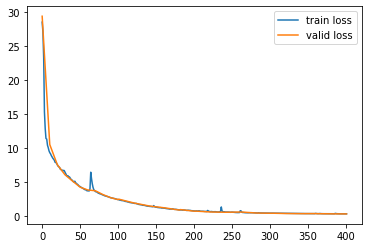

--------------------------------------------------
Checkpoint data:
Best train loss: 0.354 at epoch 400/402
Best valid loss: 0.344 at epoch 401/402
Train time 3h
--------------------------------------------------
batch 0 / 27
batch 1 / 27
batch 2 / 27
batch 3 / 27
batch 5 / 27
batch 6 / 27
batch 7 / 27
batch 8 / 27
batch 9 / 27
batch 10 / 27
batch 11 / 27
batch 12 / 27
batch 13 / 27
batch 14 / 27
batch 15 / 27
batch 16 / 27
batch 17 / 27
batch 18 / 27
batch 19 / 27
batch 20 / 27
batch 21 / 27
batch 22 / 27
batch 23 / 27
batch 24 / 27
batch 25 / 27
batch 26 / 27


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# load model and evaluate
_, _, t_history, v_history=load_checkpoint("no_shifting_checkpoint_2023-03-20_1702.pth")
plot_learning_curve(t_history, v_history)
m1_mse, m1_acc, m1_psnr, m1_ssim, m1_psnr_grid, m1_ssim_grid, m1_psnr_ct, m1_ssim_ct, m1_psnr_grid_ct, m1_ssim_grid_ct = run_evaluation(test_dataloader, checkpoint_file="no_shifting_checkpoint_2023-03-20_1702.pth")

In [16]:
from tabulate import tabulate
results = [["Model", "MSE", "Accuracy"],
           ["Model 1A",
            "{:.3f}+-{:.2f}".format(m1_mse[0], m1_mse[1]),
            "{:.3f}+-{:.2f}".format(m1_acc[0], m1_acc[1]),
            ]]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Model 1A",
            "{:.3f}+-{:.2f}".format(m1_psnr[0], m1_psnr[1]),
            "{:.3f}+-{:.2f}".format(m1_ssim[0], m1_ssim[1]),
            "{:.3f}+-{:.2f}".format(m1_psnr_grid[0], m1_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(m1_ssim_grid[0], m1_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(m1_psnr_ct[0], m1_psnr_ct[1]),
            "{:.3f}+-{:.2f}".format(m1_ssim_ct[0], m1_ssim_ct[1]),
            "{:.3f}+-{:.2f}".format(m1_psnr_grid_ct[0], m1_psnr_grid_ct[1]),
            "{:.3f}+-{:.2f}".format(m1_ssim_grid_ct[0], m1_ssim_grid_ct[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═════════════════╤═════════════╕
│ Model    │ MSE             │ Accuracy    │
╞══════════╪═════════════════╪═════════════╡
│ Model 1A │ 440.888+-778.80 │ 0.999+-0.00 │
╘══════════╧═════════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 20.726+-2.53    │ 0.665+-0.10     │ nan+-nan   │ nan+-nan   │ 20.917+-2.80    │ 0.707+-0.09     │
╘══════════╧════════════╧════════════╧═════════════════╧═════════════════╧════════════╧════════════╧═════════════════╧═════════════════╛


## Model with shifting 1B

--------------------------------------------------
Checkpoint data:
Best train loss: 1.499 at epoch 437/442
Best valid loss: 1.237 at epoch 402/442
Train time 8h
--------------------------------------------------


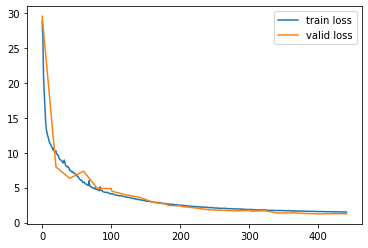

--------------------------------------------------
Checkpoint data:
Best train loss: 1.499 at epoch 437/442
Best valid loss: 1.237 at epoch 402/442
Train time 8h
--------------------------------------------------
batch 0 / 27
batch 1 / 27
batch 2 / 27
batch 3 / 27
batch 4 / 27
batch 5 / 27
batch 6 / 27
batch 7 / 27
batch 8 / 27
batch 9 / 27
batch 10 / 27
batch 11 / 27
batch 12 / 27
batch 13 / 27
batch 14 / 27
batch 15 / 27
batch 16 / 27
batch 17 / 27
batch 18 / 27
batch 19 / 27
batch 20 / 27
batch 21 / 27
batch 22 / 27
batch 23 / 27
batch 24 / 27
batch 25 / 27
batch 26 / 27


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
# load model and evaluate
_, _, t_history, v_history = load_checkpoint("model_shifting_checkpoint_2023-03-20_2257.pth")
plot_learning_curve(t_history, v_history)
m2_mse, m2_acc, m2_psnr, m2_ssim, m2_psnr_grid, m2_ssim_grid, m2_psnr_ct, m2_ssim_ct, m2_psnr_grid_ct, m2_ssim_grid_ct = run_evaluation(test_dataloader, checkpoint_file="model_shifting_checkpoint_2023-03-20_2257.pth")

In [18]:
from tabulate import tabulate
results = [["Model", "MSE", "Accuracy","PSNR", "SSIM","PSNR grid", "SSIM grid"],
           ["Model 1B",
            "{:.3f}+-{:.2f}".format(m2_mse[0], m2_mse[1]),
            "{:.3f}+-{:.2f}".format(m2_acc[0], m2_acc[1])]]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(m2_psnr[0], m2_psnr[1]),
            "{:.3f}+-{:.2f}".format(m2_ssim[0], m2_ssim[1]),
            "{:.3f}+-{:.2f}".format(m2_psnr_grid[0], m2_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(m2_ssim_grid[0], m2_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(m2_psnr_ct[0], m2_psnr_ct[1]),
            "{:.3f}+-{:.2f}".format(m2_ssim_ct[0], m2_ssim_ct[1]),
            "{:.3f}+-{:.2f}".format(m2_psnr_grid_ct[0], m2_psnr_grid_ct[1]),
            "{:.3f}+-{:.2f}".format(m2_ssim_grid_ct[0], m2_ssim_grid_ct[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═════════════════╤═════════════╕
│ Model    │ MSE             │ Accuracy    │
╞══════════╪═════════════════╪═════════════╡
│ Model 1B │ 530.950+-871.49 │ 0.992+-0.01 │
╘══════════╧═════════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 20.574+-2.59    │ 0.662+-0.10     │ nan+-nan   │ nan+-nan   │ 20.832+-2.90    │ 0.706+-0.10     │
╘══════════╧════════════╧════════════╧═════════════════╧═════════════════╧════════════╧════════════╧═════════════════╧═════════════════╛


## Model with shifting and data augmentations 1C

--------------------------------------------------
Checkpoint data:
Best train loss: 9.010 at epoch 39/41
Best valid loss: 6.964 at epoch 40/41
Train time 4h
--------------------------------------------------


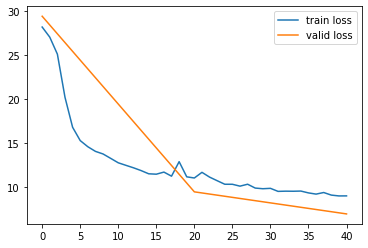

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

--------------------------------------------------
Checkpoint data:
Best train loss: 9.010 at epoch 39/41
Best valid loss: 6.964 at epoch 40/41
Train time 4h
--------------------------------------------------
batch 0 / 54
batch 1 / 54
batch 2 / 54
batch 3 / 54
batch 4 / 54
batch 5 / 54
batch 6 / 54
batch 7 / 54
batch 8 / 54
batch 9 / 54
batch 10 / 54
batch 11 / 54
batch 12 / 54
batch 13 / 54
batch 14 / 54
batch 15 / 54
batch 16 / 54
batch 17 / 54
batch 18 / 54
batch 19 / 54
batch 20 / 54


In [ ]:
# load model and evaluate
_, _, t_history, v_history = load_checkpoint("augmented_checkpoint_2023-03-20_2158.pth")
plot_learning_curve(t_history, v_history)
m3_mse, m3_acc, m3_psnr, m3_ssim, m3_psnr_grid, m3_ssim_grid = run_evaluation(test_dataloader, checkpoint_file="augmented_checkpoint_2023-03-20_2158.pth")

In [ ]:
from tabulate import tabulate
results = [["Model", "MSE", "Accuracy","PSNR", "SSIM","PSNR grid", "SSIM grid"],
           ["Model 1C",
            "{:.3f}+-{:.2f}".format(m3_mse[0], m3_mse[1]),
            "{:.3f}+-{:.2f}".format(m3_acc[0], m3_acc[1]),
            "{:.3f}+-{:.2f}".format(m3_psnr[0], m3_psnr[1]),
            "{:.3f}+-{:.2f}".format(m3_ssim[0], m3_ssim[1]),
            "{:.3f}+-{:.2f}".format(m3_psnr_grid[0], m3_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(m3_ssim_grid[0], m3_ssim_grid[1])]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═════════════════╤═════════════╤══════════════╤═════════════╤══════════════╤═════════════╕
│ Model    │ MSE             │ Accuracy    │ PSNR         │ SSIM        │ PSNR grid    │ SSIM grid   │
╞══════════╪═════════════════╪═════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ Model 1C │ 459.306+-676.83 │ 0.956+-0.05 │ 26.247+-7.17 │ 0.906+-0.09 │ 20.061+-2.85 │ 0.653+-0.10 │
╘══════════╧═════════════════╧═════════════╧══════════════╧═════════════╧══════════════╧═════════════╛


# Natural Data

In [ ]:
TEST_DATA = "full_dataset_valid_2023-02-19"
!unzip -d "$TEST_DATA"/ /content/drive/MyDrive/"$TEST_DATA".zip # unziping test data

test_dataset = TaiChiDataset(log_file=TEST_DATA+'/sample_ids.txt',
                              root_dir=TEST_DATA,
                              check=True,
                              transform=transforms.Compose([ToTensor()]))

print(len(test_dataset))
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

## Baseline

In [24]:
baseline_mse, baseline_acc, baseline_psnr, baseline_ssim, baseline_psnr_grid, baseline_ssim_grid, baseline_psnr_CT, baseline_ssim_CT, baseline_psnr_grid_CT, baseline_ssim_grid_CT = run_evaluation(test_dataloader)
from tabulate import tabulate

results = [["Model", "MSE", "Accuracy"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(baseline_mse[0], baseline_mse[1]),
            "{:.3f}+-{:.2f}".format(baseline_acc[0], baseline_acc[1])]
            ]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(baseline_psnr[0], baseline_psnr[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim[0], baseline_ssim[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_grid[0], baseline_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_grid[0], baseline_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_CT[0], baseline_psnr_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_CT[0], baseline_ssim_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_psnr_grid_CT[0], baseline_psnr_grid_CT[1]),
            "{:.3f}+-{:.2f}".format(baseline_ssim_grid_CT[0], baseline_ssim_grid_CT[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

batch 0 / 15
batch 1 / 15
batch 2 / 15
batch 3 / 15
batch 4 / 15
batch 5 / 15
batch 6 / 15
batch 7 / 15
batch 8 / 15
batch 9 / 15
batch 10 / 15
batch 11 / 15
batch 12 / 15
batch 13 / 15
batch 14 / 15
╒══════════╤═════════════════╤═════════════╕
│ Model    │ MSE             │ Accuracy    │
╞══════════╪═════════════════╪═════════════╡
│ Baseline │ 115.655+-291.65 │ 0.953+-0.05 │
╘══════════╧═════════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 18.961+-2.16    │ 0.692+-0.09     │ nan+-nan   │ nan+-nan   │ 19.670+-2.30    │ 0.730+-0.08     │
╘══════════╧════════════╧══

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Model 2A

--------------------------------------------------
Checkpoint data:
Best train loss: 0.779 at epoch 120/121
Best valid loss: 3.119 at epoch 60/121
Train time 6h
--------------------------------------------------


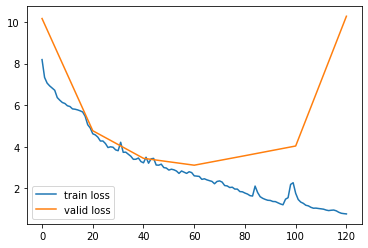

--------------------------------------------------
Checkpoint data:
Best train loss: 0.779 at epoch 120/121
Best valid loss: 3.119 at epoch 60/121
Train time 6h
--------------------------------------------------
batch 0 / 15
batch 1 / 15
batch 2 / 15
batch 3 / 15
batch 4 / 15
batch 5 / 15
batch 6 / 15
batch 7 / 15
batch 8 / 15
batch 9 / 15
batch 10 / 15
batch 11 / 15
batch 12 / 15
batch 13 / 15
batch 14 / 15


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
# load model and evaluate
_, _, t_history, v_history = load_checkpoint("natural_checkpoint_2023-03-21_0536.pth")
plot_learning_curve(t_history, v_history)
m4_mse, m4_acc, m4_psnr, m4_ssim, m4_psnr_grid, m4_ssim_grid, m4_psnr_ct, m4_ssim_ct, m4_psnr_grid_ct, m4_ssim_grid_ct = run_evaluation(test_dataloader, checkpoint_file="natural_checkpoint_2023-03-21_0536.pth")

In [23]:
from tabulate import tabulate
results = [["Model", "MSE", "Accuracy","PSNR", "SSIM","PSNR grid", "SSIM grid"],
           ["Model 1B",
            "{:.3f}+-{:.2f}".format(m4_mse[0], m4_mse[1]),
            "{:.3f}+-{:.2f}".format(m4_acc[0], m4_acc[1])]]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(m4_psnr[0], m4_psnr[1]),
            "{:.3f}+-{:.2f}".format(m4_ssim[0], m4_ssim[1]),
            "{:.3f}+-{:.2f}".format(m4_psnr_grid[0], m4_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(m4_ssim_grid[0], m4_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(m4_psnr_ct[0], m4_psnr_ct[1]),
            "{:.3f}+-{:.2f}".format(m4_ssim_ct[0], m4_ssim_ct[1]),
            "{:.3f}+-{:.2f}".format(m4_psnr_grid_ct[0], m4_psnr_grid_ct[1]),
            "{:.3f}+-{:.2f}".format(m4_ssim_grid_ct[0], m4_ssim_grid_ct[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤════════════════╤═════════════╕
│ Model    │ MSE            │ Accuracy    │
╞══════════╪════════════════╪═════════════╡
│ Model 1B │ 43.244+-105.05 │ 0.962+-0.04 │
╘══════════╧════════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 19.776+-2.02    │ 0.706+-0.09     │ nan+-nan   │ nan+-nan   │ 20.492+-2.12    │ 0.742+-0.08     │
╘══════════╧════════════╧════════════╧═════════════════╧═════════════════╧════════════╧════════════╧═════════════════╧═════════════════╛


## Model 2B

--------------------------------------------------
Checkpoint data:
Best train loss: 1.786 at epoch 178/180
Best valid loss: 2.999 at epoch 119/180
Train time 3h
--------------------------------------------------


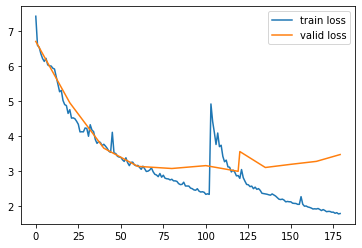

--------------------------------------------------
Checkpoint data:
Best train loss: 1.786 at epoch 178/180
Best valid loss: 2.999 at epoch 119/180
Train time 3h
--------------------------------------------------
batch 0 / 15
batch 1 / 15
batch 2 / 15
batch 3 / 15
batch 4 / 15
batch 5 / 15
batch 6 / 15
batch 7 / 15
batch 8 / 15
batch 9 / 15
batch 10 / 15
batch 11 / 15
batch 12 / 15
batch 13 / 15
batch 14 / 15


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# load model and evaluate
_, _, t_history, v_history = load_checkpoint("shift_natural_checkpoint_2023-03-21_1740.pth")
plot_learning_curve(t_history, v_history)
m5_mse, m5_acc, m5_psnr, m5_ssim, m5_psnr_grid, m5_ssim_grid, m5_psnr_ct, m5_ssim_ct, m5_psnr_grid_ct, m5_ssim_grid_ct = run_evaluation(test_dataloader, checkpoint_file="shift_natural_checkpoint_2023-03-21_1740.pth")

In [26]:
from tabulate import tabulate
results = [["Model", "MSE", "Accuracy","PSNR", "SSIM","PSNR grid", "SSIM grid"],
           ["Model 2B",
            "{:.3f}+-{:.2f}".format(m5_mse[0], m5_mse[1]),
            "{:.3f}+-{:.2f}".format(m5_acc[0], m5_acc[1])]]

results_r = [["Model", "NN: PSNR", "NN: SSIM","NN: PSNR grid", "NN: SSIM grid", "CT: PSNR", "CT: SSIM","CT: PSNR grid", "CT: SSIM grid"],
           ["Baseline",
            "{:.3f}+-{:.2f}".format(m5_psnr[0], m5_psnr[1]),
            "{:.3f}+-{:.2f}".format(m5_ssim[0], m5_ssim[1]),
            "{:.3f}+-{:.2f}".format(m5_psnr_grid[0], m5_psnr_grid[1]),
            "{:.3f}+-{:.2f}".format(m5_ssim_grid[0], m5_ssim_grid[1]),
            "{:.3f}+-{:.2f}".format(m5_psnr_ct[0], m5_psnr_ct[1]),
            "{:.3f}+-{:.2f}".format(m5_ssim_ct[0], m5_ssim_ct[1]),
            "{:.3f}+-{:.2f}".format(m5_psnr_grid_ct[0], m5_psnr_grid_ct[1]),
            "{:.3f}+-{:.2f}".format(m5_ssim_grid_ct[0], m5_ssim_grid_ct[1])]
            ]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(results_r, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════╤═════════════╕
│ Model    │ MSE           │ Accuracy    │
╞══════════╪═══════════════╪═════════════╡
│ Model 2B │ 39.258+-90.07 │ 0.962+-0.04 │
╘══════════╧═══════════════╧═════════════╛
╒══════════╤════════════╤════════════╤═════════════════╤═════════════════╤════════════╤════════════╤═════════════════╤═════════════════╕
│ Model    │ NN: PSNR   │ NN: SSIM   │ NN: PSNR grid   │ NN: SSIM grid   │ CT: PSNR   │ CT: SSIM   │ CT: PSNR grid   │ CT: SSIM grid   │
╞══════════╪════════════╪════════════╪═════════════════╪═════════════════╪════════════╪════════════╪═════════════════╪═════════════════╡
│ Baseline │ nan+-nan   │ nan+-nan   │ 19.740+-2.00    │ 0.705+-0.09     │ nan+-nan   │ nan+-nan   │ 20.426+-2.09    │ 0.740+-0.08     │
╘══════════╧════════════╧════════════╧═════════════════╧═════════════════╧════════════╧════════════╧═════════════════╧═════════════════╛
